In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random
import torch.optim as optim
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor

# Define the MLP-based model

In [ ]:
class MLP_Contrastive(nn.Module):
    def __init__(
        self,
        d_esm: int,
        embedding_hidden_dims: list[int],
        d_emb: int,
        contrast_type: str,
        output_hidden_dims: list[int],
        dropout_rate: float = 0.1,
    ):
        """
        A fully differentiable contrastive model with only MLPs.

        Args:
        -----
        d_esm: int
            Dimension of the input ESM embeddings.
        embedding_hidden_dims: list[int]
            Hidden layer sizes for the shared embedding MLP.
            e.g. [512,256] means d_esm->512->256->d_emb.
        d_emb: int
            Output dimension of the shared embedding MLP.
        contrast_type: {"subtract","concat"}
            How to form the contrastive vector.
        output_hidden_dims: list[int]
            Hidden layer sizes for the final MLP.
            e.g. [128,64] means input_dim->128->64->1.
        dropout_rate: float
        """
        super().__init__()
        assert contrast_type in ("subtract","concat")
        self.contrast_type = contrast_type

        # ---- Shared embedding MLP: d_esm -> ... -> d_emb ----
        dims = [d_esm] + embedding_hidden_dims + [d_emb]
        layers = []
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.Dropout(dropout_rate))
        self.embed_mlp = nn.Sequential(*layers)

        # ---- Final output MLP: contrastive_dim+1 -> ... -> 1 ----
        contrast_dim = d_emb if contrast_type=="subtract" else 2*d_emb
        in_dim = contrast_dim + 1
        dims = [in_dim] + output_hidden_dims + [1]
        layers = []
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.Dropout(dropout_rate))
        self.output_mlp = nn.Sequential(*layers)

    def forward(self, emb1, emb2, fit1):
        """
        emb1, emb2: (N, L, d_esm)
        fit1:       (N, 1)

        Returns:
        --------
        logits:    (N,)  scalar predictions
        """
        # 1) mean over sequence length
        v1 = emb1.mean(dim=1)  # (N, d_esm)
        v2 = emb2.mean(dim=1)

        # 2) shared embedding MLP
        e1 = self.embed_mlp(v1)  # (N, d_emb)
        e2 = self.embed_mlp(v2)

        # 3) contrastive vector
        if self.contrast_type == "subtract":
            c = e2 - e1          # (N, d_emb)
        else:  # concat
            c = torch.cat([e1, e2], dim=1)  # (N, 2*d_emb)

        # 4) append the fitness of the first variant as an 1D feature
        x = torch.cat([c, fit1], dim=1)     # (N, contrast_dim+1)

        # 5) final MLP to scalar
        out = self.output_mlp(x)           # (N, 1)
        return out.squeeze(1)              # (N,)

# Define the CNN-based model

In [ ]:
class BasicBlock1D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm1d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes,
                               kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm1d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        return self.relu(out)


class CNN_Contrastive(nn.Module):
    def __init__(self, d_esm: int, use_first_fitness: bool = False):
        """
        CNN‐based contrastive model using a 1D-ResNet18 backbone.

        Args:
        -----
        d_esm: int
            Dimension of the input ESM embeddings.
        use_first_fitness: bool
            If True, append the fitness value of the first variant before the final FC.
        """
        super().__init__()
        self.use_first_fitness = use_first_fitness
        self.inplanes = 64

        # --- initial conv/bn/relu/pool (1D) ---
        self.conv1   = nn.Conv1d(d_esm, 64,
                                 kernel_size=7, stride=2,
                                 padding=3, bias=False)
        self.bn1     = nn.BatchNorm1d(64)
        self.relu    = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3,
                                    stride=2, padding=1)

        # --- the 4 ResNet layers (2 blocks each) ---
        self.layer1 = self._make_layer(BasicBlock1D,  64, 2)
        self.layer2 = self._make_layer(BasicBlock1D, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock1D, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock1D, 512, 2, stride=2)

        # --- global pooling + final FC ---
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        fc_in = 512 * BasicBlock1D.expansion + (1 if use_first_fitness else 0)
        self.fc = nn.Linear(fc_in, 1)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes,
                          planes * block.expansion,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes,
                            stride=stride,
                            downsample=downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, emb1, emb2, fit1= None):
        """
        Args:
        -----
        emb1, emb2: (N, L, d_esm)
            ESM embeddings for sequence 1 and 2.
        fit1: (N, 1), optional
            The 1‐D fitness feature of the first variant to append before the final FC.

        Returns:
        --------
        out: (N,)
            The scalar logit/regression output.
        """
        # compute difference and permute to (N, d_esm, L)
        x = emb2 - emb1
        x = x.permute(0, 2, 1)

        # stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # global pooling
        x = self.avgpool(x)     # (N, 512, 1)
        x = torch.flatten(x, 1) # (N, 512)

        # 5) optionally append Fitness 1
        if self.use_first_fitness and fit1 is not None:
            x = torch.cat([x, fit1], dim=1)  # (N, 513)

        # 6) final FC -> scalar
        out = self.fc(x)  # (N, 1)
        return out.squeeze(1)  # (N,)

# Define the cross attention-based model

In [ ]:
class CrossAttnContrastive(nn.Module):
    def __init__(
        self,
        d_esm: int,
        d_emb: int,
        hidden_dims: list[int],
        contrast_type: str = "subtract",
        dropout_rate: float = 0.1,
    ):
        """
        Cross‐attention contrastive model.

        Args:
        -----
        d_esm: int
            Dimension of the input ESM embeddings (hidden size).
        d_emb: int
            Dimension of the key/value embeddings and query.
        hidden_dims: list[int]
            Hidden layer sizes for the final MLP.
        contrast_type: {"subtract","concat"}
            How to form the contrastive vector.
        dropout_rate: float
            Dropout probability in the final MLP.
        """
        super().__init__()
        assert contrast_type in ("subtract", "concat")
        self.contrast_type = contrast_type
        self.d_emb = d_emb

        # Cross‐attention parameters
        self.w_k = nn.Linear(d_esm, d_emb, bias=False)
        self.w_v = nn.Linear(d_esm, d_emb, bias=False)
        self.query = nn.Parameter(torch.randn(d_emb))

        # Final MLP:
        contrast_dim = d_emb if contrast_type == "subtract" else 2 * d_emb
        mlp_dims = [contrast_dim+1] + hidden_dims + [1]
        layers = []
        for i in range(len(mlp_dims) - 1):
            layers.append(nn.Linear(mlp_dims[i], mlp_dims[i+1]))
            if i < len(mlp_dims) - 2:
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.Dropout(dropout_rate))
        self.output_mlp = nn.Sequential(*layers)

    def forward(self, emb1, emb2, fit1) -> torch.Tensor:
        """
        emb1, emb2: (N, L, d_esm)
        fit1: (N, 1) fitness of the first variants
        Returns:
        --------
        logits: (N,) scalar predictions
        """
        N, L, _ = emb1.shape

        # -- Cross‐attention pooling for emb1 and emb2 --
        # Compute keys and values: (N, L, d_emb)
        K1 = self.w_k(emb1)
        V1 = self.w_v(emb1)
        K2 = self.w_k(emb2)
        V2 = self.w_v(emb2)

        # Prepare query: (1, d_emb) -> (N, 1, d_emb)
        Q = self.query.unsqueeze(0).unsqueeze(1).expand(N, 1, self.d_emb)

        # Scaled dot‐product attention scores: (N, 1, L)
        scale = math.sqrt(self.d_emb)
        attn1 = F.softmax((Q @ K1.transpose(1, 2)) / scale, dim=-1)
        attn2 = F.softmax((Q @ K2.transpose(1, 2)) / scale, dim=-1)

        # Weighted sum of values: (N, 1, d_emb) -> (N, d_emb)
        v1 = (attn1 @ V1).squeeze(1)
        v2 = (attn2 @ V2).squeeze(1)

        # -- Contrastive embedding --
        if self.contrast_type == "subtract":
            c = v2 - v1          # (N, d_emb)
        else:  # "concat"
            c = torch.cat([v1, v2], dim=1)  # (N, 2*d_emb)
        c = torch.cat([c, fit1], dim=1)

        # -- Final MLP to scalar logit --
        out = self.output_mlp(c).squeeze(1)  # (N,)
        return out

# Define the multi-layer transformer model

In [ ]:
class TransformerBlock1D(nn.Module):
    def __init__(self, d_model, nhead=8, dim_ff=2048, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        # separate Q, K, V projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.attn   = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm2  = nn.LayerNorm(d_model)
        self.ff     = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):  # x: (N, L, d_model)
        # Pre-normalization
        y = self.norm1(x)
        # Project to Q, K, V and transpose for MHA
        q = self.q_proj(y).transpose(0,1)  # (L, N, d_model)
        k = self.k_proj(y).transpose(0,1)
        v = self.v_proj(y).transpose(0,1)
        # Scaled dot-product
        y2, _ = self.attn(q, k, v)
        # back to (N, L, d_model)
        x = x + y2.transpose(0,1)
        # Feed-forward with residual
        y = self.norm2(x)
        x = x + self.ff(y)
        return x

class MLT_Contrastive(nn.Module):
    def __init__(
        self,
        d_esm: int,
        d_model: int = 512,
        nhead: int = 8,
        dim_ff: int = 2048,
        num_groups: int = 3,
        blocks_per_group: int = 2,
        max_len: int = 101,
        use_first_fitness: bool = False,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.use_first_fitness = use_first_fitness
        # Stem projection + positional embedding
        self.proj    = nn.Linear(d_esm, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)

        # Hierarchical transformer groups
        self.groups = nn.ModuleList()
        for _ in range(num_groups):
            blocks = [
                TransformerBlock1D(d_model, nhead, dim_ff, dropout_rate)
                for _ in range(blocks_per_group)
            ]
            self.groups.append(nn.Sequential(*blocks))

        # Global pooling + final FC
        self.pool = nn.AdaptiveAvgPool1d(1)
        fc_in = d_model + (1 if use_first_fitness else 0)
        self.fc  = nn.Linear(fc_in, 1)

    def forward(self, emb1: torch.Tensor, emb2: torch.Tensor, fit1: torch.Tensor = None):
        # emb1, emb2: (N, L, d_esm)
        x = emb2 - emb1  # (N, L, d_esm)

        # Stem + position
        x = self.proj(x)  # (N, L, d_model)
        N, L, _ = x.shape
        positions = torch.arange(L, device=x.device).unsqueeze(0)
        x = x + self.pos_emb(positions)

        # Transformer groups + pooling
        for group in self.groups:
            x = group(x)  # (N, L, d_model)
            x = F.avg_pool1d(
                x.transpose(1,2), kernel_size=2, stride=2
            ).transpose(1,2)  # halve length

        # Global pool
        x = self.pool(x.transpose(1,2)).squeeze(-1)  # (N, d_model)

        # Optional fitness concat
        if self.use_first_fitness and fit1 is not None:
            x = torch.cat([x, fit1], dim=1)

        # Final regression
        return self.fc(x).squeeze(-1)

# Define functions for training

In [ ]:
def load_data(idx1, idx2, fit1, labels, emb, batch, batch_size, device):
    """
    Returns:
      emb1_batch: (B, L, d_esm) torch.Tensor
      emb2_batch: (B, L, d_esm) torch.Tensor
      fit1_batch: (B, 1)      torch.Tensor
      labels_batch:(B,)       torch.Tensor
    """
    start = batch * batch_size
    end   = min(start + batch_size, len(labels))
    b_idx1 = idx1[start:end]
    b_idx2 = idx2[start:end]
    b_fit1 = np.array(fit1[start:end], dtype=np.float32).reshape(-1,1)
    b_lbl  = np.array(labels[start:end], dtype=np.float32).reshape(-1,1)

    emb1 = emb[np.array(b_idx1)]
    emb2 = emb[np.array(b_idx2)]
    emb1 = torch.from_numpy(emb1).float().to(device)
    emb2 = torch.from_numpy(emb2).float().to(device)
    fit1 = torch.from_numpy(b_fit1).float().to(device)
    lbl  = torch.from_numpy(b_lbl).squeeze(1).float().to(device)
    return emb1, emb2, fit1, lbl


def train_epoch(model, optimizer, idx1, idx2, fit1, labels, emb, batch_size, epoch, device, train_frac):
    model.train()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total = 0
    num_batches = math.ceil(len(labels) / batch_size)
    batch_set_size = math.ceil(num_batches/train_frac)
    batch_set_idx = (epoch-1)%train_frac
    start_b = batch_set_idx * batch_set_size
    end_b = (batch_set_idx+1) * batch_set_size
    for b in tqdm(list(range(num_batches))[start_b: end_b], desc=f"Epoch {epoch}"):
        e1, e2, f1, y = load_data(idx1, idx2, fit1, labels, emb, b, batch_size, device)
        preds = model(e1, e2, f1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * preds.size(0)
        total += preds.size(0)
    return running_loss / total


def test_epoch(model, idx1, idx2, fit1, labels, emb, batch_size, epoch, device, test_frac=None):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total = 0
    all_preds = []
    all_targets = []
    num_batches = math.ceil(len(labels) / batch_size)
    b_set = list(range(num_batches))
    if test_frac:
        b_set = random.sample(range(num_batches), math.ceil(num_batches/test_frac))
    with torch.no_grad():
        for b in tqdm(b_set, desc=f"Epoch {epoch}"):
            e1, e2, f1, y = load_data(idx1, idx2, fit1, labels, emb, b, batch_size, device)
            preds = model(e1, e2, f1)
            loss = criterion(preds, y)
            running_loss += loss.item() * preds.size(0)
            total += preds.size(0)
            all_preds.append(preds.detach().cpu().numpy())
            all_targets.append(y.detach().cpu().numpy())
    avg_loss = running_loss / total
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    corr, _ = spearmanr(all_preds, all_targets)
    return avg_loss, corr, all_preds, all_targets

# Train the model and save results

Zero-skill test: 100%|██████████| 3520/3520 [01:07<00:00, 52.05it/s]


Zero‐skill Train ▶ loss=6.8871, Spear=0.6815
Zero‐skill Test  ▶ loss=6.9369, Spear=0.6876


Epoch 1: 100%|██████████| 3520/3520 [01:30<00:00, 39.05it/s]


Epoch   1 ▶ Train Loss 3.2802 | Test Loss 16.1857 | Spear 0.3795


Epoch 2: 100%|██████████| 3520/3520 [01:30<00:00, 39.07it/s]


Epoch   2 ▶ Train Loss 3.7276 | Test Loss 9.4887 | Spear 0.3217


Epoch 3: 100%|██████████| 3520/3520 [01:35<00:00, 36.95it/s]


Epoch   3 ▶ Train Loss 2.5005 | Test Loss 11.0930 | Spear 0.2939


Epoch 4: 100%|██████████| 3520/3520 [01:29<00:00, 39.53it/s]


Epoch   4 ▶ Train Loss 3.2848 | Test Loss 3.9275 | Spear 0.6581


Epoch 5: 100%|██████████| 3520/3520 [01:31<00:00, 38.61it/s]


Epoch   5 ▶ Train Loss 2.3633 | Test Loss 3.5215 | Spear 0.7056


Epoch 6: 100%|██████████| 3520/3520 [01:33<00:00, 37.78it/s]


Epoch   6 ▶ Train Loss 1.8379 | Test Loss 3.6938 | Spear 0.6978


Epoch 7: 100%|██████████| 3520/3520 [01:28<00:00, 39.93it/s]


Epoch   7 ▶ Train Loss 1.5801 | Test Loss 3.6341 | Spear 0.7100


Epoch 8: 100%|██████████| 3520/3520 [01:28<00:00, 39.79it/s]


Epoch   8 ▶ Train Loss 1.4257 | Test Loss 3.4037 | Spear 0.7243


Epoch 9: 100%|██████████| 3520/3520 [01:32<00:00, 37.91it/s]


Epoch   9 ▶ Train Loss 1.3021 | Test Loss 3.4762 | Spear 0.7194


Epoch 10: 100%|██████████| 3520/3520 [01:20<00:00, 43.68it/s]


Epoch  10 ▶ Train Loss 1.2183 | Test Loss 3.5073 | Spear 0.7186


Epoch 11: 100%|██████████| 3520/3520 [01:33<00:00, 37.65it/s]


Epoch  11 ▶ Train Loss 1.1453 | Test Loss 3.4102 | Spear 0.7295


Epoch 12: 100%|██████████| 3520/3520 [01:33<00:00, 37.63it/s]


Epoch  12 ▶ Train Loss 1.0701 | Test Loss 3.3970 | Spear 0.7288


Epoch 13: 100%|██████████| 3520/3520 [01:27<00:00, 40.36it/s]


Epoch  13 ▶ Train Loss 1.0326 | Test Loss 3.2322 | Spear 0.7400


Epoch 14: 100%|██████████| 3520/3520 [01:34<00:00, 37.23it/s]


Epoch  14 ▶ Train Loss 0.9736 | Test Loss 3.3983 | Spear 0.7293


Epoch 15: 100%|██████████| 3520/3520 [01:35<00:00, 37.02it/s]


Epoch  15 ▶ Train Loss 0.9395 | Test Loss 3.2260 | Spear 0.7447


Epoch 16: 100%|██████████| 3520/3520 [01:25<00:00, 41.10it/s]


Epoch  16 ▶ Train Loss 0.8987 | Test Loss 3.3848 | Spear 0.7313


Epoch 17: 100%|██████████| 3520/3520 [01:33<00:00, 37.58it/s]


Epoch  17 ▶ Train Loss 0.8695 | Test Loss 3.3555 | Spear 0.7367


Epoch 18: 100%|██████████| 3520/3520 [01:36<00:00, 36.34it/s]


Epoch  18 ▶ Train Loss 0.8378 | Test Loss 3.3877 | Spear 0.7346


Epoch 19: 100%|██████████| 3520/3520 [01:29<00:00, 39.36it/s]


Epoch  19 ▶ Train Loss 0.8124 | Test Loss 3.2488 | Spear 0.7451


Epoch 20: 100%|██████████| 3520/3520 [01:35<00:00, 36.86it/s]


Epoch  20 ▶ Train Loss 0.7898 | Test Loss 3.2281 | Spear 0.7416


Epoch 21: 100%|██████████| 3520/3520 [01:33<00:00, 37.51it/s]


Epoch  21 ▶ Train Loss 0.7636 | Test Loss 3.2258 | Spear 0.7478


Epoch 22: 100%|██████████| 3520/3520 [01:33<00:00, 37.76it/s]


Epoch  22 ▶ Train Loss 0.7447 | Test Loss 3.2530 | Spear 0.7409


Epoch 23: 100%|██████████| 3520/3520 [01:28<00:00, 39.70it/s]


Epoch  23 ▶ Train Loss 0.7156 | Test Loss 3.2400 | Spear 0.7423


Epoch 24: 100%|██████████| 3520/3520 [01:35<00:00, 36.94it/s]


Epoch  24 ▶ Train Loss 0.7015 | Test Loss 3.1920 | Spear 0.7509


Epoch 25: 100%|██████████| 3520/3520 [01:33<00:00, 37.65it/s]


Epoch  25 ▶ Train Loss 0.6793 | Test Loss 3.0570 | Spear 0.7516


Epoch 26: 100%|██████████| 3520/3520 [01:27<00:00, 40.05it/s]


Epoch  26 ▶ Train Loss 0.6633 | Test Loss 3.1282 | Spear 0.7569


Epoch 27: 100%|██████████| 3520/3520 [01:32<00:00, 38.01it/s]


Epoch  27 ▶ Train Loss 0.6520 | Test Loss 3.0893 | Spear 0.7575


Epoch 28: 100%|██████████| 3520/3520 [01:26<00:00, 40.53it/s]


Epoch  28 ▶ Train Loss 0.6455 | Test Loss 3.0574 | Spear 0.7633


Epoch 29: 100%|██████████| 3520/3520 [01:30<00:00, 39.09it/s]


Epoch  29 ▶ Train Loss 0.6190 | Test Loss 3.1237 | Spear 0.7556


Epoch 30: 100%|██████████| 3520/3520 [01:28<00:00, 39.96it/s]


Epoch  30 ▶ Train Loss 0.6081 | Test Loss 3.1002 | Spear 0.7559


Epoch 31: 100%|██████████| 3520/3520 [01:33<00:00, 37.66it/s]


Epoch  31 ▶ Train Loss 0.5863 | Test Loss 3.2390 | Spear 0.7513


Epoch 32: 100%|██████████| 3520/3520 [01:32<00:00, 37.97it/s]


Epoch  32 ▶ Train Loss 0.5873 | Test Loss 3.1361 | Spear 0.7573


Epoch 33: 100%|██████████| 3520/3520 [01:19<00:00, 44.19it/s]


Epoch  33 ▶ Train Loss 0.5677 | Test Loss 3.0735 | Spear 0.7569


Epoch 34: 100%|██████████| 3520/3520 [01:29<00:00, 39.19it/s]


Epoch  34 ▶ Train Loss 0.5627 | Test Loss 2.9877 | Spear 0.7674


Epoch 35: 100%|██████████| 3520/3520 [01:31<00:00, 38.39it/s]


Epoch  35 ▶ Train Loss 0.5448 | Test Loss 2.8904 | Spear 0.7675


Epoch 36: 100%|██████████| 3520/3520 [01:30<00:00, 38.99it/s]


Epoch  36 ▶ Train Loss 0.5274 | Test Loss 3.0082 | Spear 0.7684


Epoch 37: 100%|██████████| 3520/3520 [01:31<00:00, 38.49it/s]


Epoch  37 ▶ Train Loss 0.5252 | Test Loss 2.9768 | Spear 0.7670


Epoch 38: 100%|██████████| 3520/3520 [01:30<00:00, 38.87it/s]


Epoch  38 ▶ Train Loss 0.5127 | Test Loss 2.8504 | Spear 0.7815


Epoch 39: 100%|██████████| 3520/3520 [01:28<00:00, 39.79it/s]


Epoch  39 ▶ Train Loss 0.5058 | Test Loss 2.9318 | Spear 0.7730


Epoch 40: 100%|██████████| 3520/3520 [01:27<00:00, 40.24it/s]


Epoch  40 ▶ Train Loss 0.4931 | Test Loss 2.9535 | Spear 0.7710


Epoch 41: 100%|██████████| 3520/3520 [01:32<00:00, 38.08it/s]


Epoch  41 ▶ Train Loss 0.4857 | Test Loss 3.0506 | Spear 0.7667


Epoch 42: 100%|██████████| 3520/3520 [01:19<00:00, 44.48it/s]


Epoch  42 ▶ Train Loss 0.4751 | Test Loss 2.9191 | Spear 0.7735


Epoch 43: 100%|██████████| 3520/3520 [01:33<00:00, 37.67it/s]


Epoch  43 ▶ Train Loss 0.4737 | Test Loss 2.8925 | Spear 0.7703


Epoch 44: 100%|██████████| 3520/3520 [01:29<00:00, 39.48it/s]


Epoch  44 ▶ Train Loss 0.4640 | Test Loss 2.7891 | Spear 0.7829


Epoch 45: 100%|██████████| 3520/3520 [01:32<00:00, 37.87it/s]


Epoch  45 ▶ Train Loss 0.4541 | Test Loss 2.8236 | Spear 0.7756


Epoch 46: 100%|██████████| 3520/3520 [01:28<00:00, 39.70it/s]


Epoch  46 ▶ Train Loss 0.4435 | Test Loss 2.8433 | Spear 0.7820


Epoch 47: 100%|██████████| 3520/3520 [01:28<00:00, 39.58it/s]


Epoch  47 ▶ Train Loss 0.4419 | Test Loss 2.8471 | Spear 0.7783


Epoch 48: 100%|██████████| 3520/3520 [01:29<00:00, 39.19it/s]


Epoch  48 ▶ Train Loss 0.4320 | Test Loss 2.8011 | Spear 0.7804


Epoch 49: 100%|██████████| 3520/3520 [01:27<00:00, 40.18it/s]


Epoch  49 ▶ Train Loss 0.4237 | Test Loss 2.7238 | Spear 0.7845


Epoch 50: 100%|██████████| 3520/3520 [01:29<00:00, 39.25it/s]


Epoch  50 ▶ Train Loss 0.4176 | Test Loss 2.7334 | Spear 0.7860


Epoch 51: 100%|██████████| 3520/3520 [01:30<00:00, 38.98it/s]


Epoch  51 ▶ Train Loss 1.0531 | Test Loss 10.7834 | Spear 0.5798


Epoch 52: 100%|██████████| 3520/3520 [01:33<00:00, 37.64it/s]


Epoch  52 ▶ Train Loss 2.2584 | Test Loss 7.0840 | Spear 0.5629


Epoch 53: 100%|██████████| 3520/3520 [01:22<00:00, 42.77it/s]


Epoch  53 ▶ Train Loss 1.4595 | Test Loss 7.8162 | Spear 0.5445


Epoch 54: 100%|██████████| 3520/3520 [01:31<00:00, 38.66it/s]


Epoch  54 ▶ Train Loss 1.0864 | Test Loss 2.4066 | Spear 0.8041


Epoch 55: 100%|██████████| 3520/3520 [01:35<00:00, 36.94it/s]


Epoch  55 ▶ Train Loss 0.5002 | Test Loss 2.5025 | Spear 0.7977


Epoch 56: 100%|██████████| 3520/3520 [01:33<00:00, 37.60it/s]


Epoch  56 ▶ Train Loss 0.4424 | Test Loss 2.4614 | Spear 0.8026


Epoch 57: 100%|██████████| 3520/3520 [01:29<00:00, 39.39it/s]


Epoch  57 ▶ Train Loss 0.4189 | Test Loss 2.5243 | Spear 0.7990


Epoch 58: 100%|██████████| 3520/3520 [01:32<00:00, 38.09it/s]


Epoch  58 ▶ Train Loss 0.4019 | Test Loss 2.4779 | Spear 0.8022


Epoch 59: 100%|██████████| 3520/3520 [01:32<00:00, 37.98it/s]


Epoch  59 ▶ Train Loss 0.3888 | Test Loss 2.4777 | Spear 0.8068


Epoch 60: 100%|██████████| 3520/3520 [01:32<00:00, 38.12it/s]


Epoch  60 ▶ Train Loss 0.3800 | Test Loss 2.5377 | Spear 0.7993


Epoch 61: 100%|██████████| 3520/3520 [01:29<00:00, 39.22it/s]


Epoch  61 ▶ Train Loss 0.3743 | Test Loss 2.4424 | Spear 0.8078


Epoch 62: 100%|██████████| 3520/3520 [01:31<00:00, 38.63it/s]


Epoch  62 ▶ Train Loss 0.3633 | Test Loss 2.5104 | Spear 0.8019


Epoch 63: 100%|██████████| 3520/3520 [01:33<00:00, 37.57it/s]


Epoch  63 ▶ Train Loss 0.3602 | Test Loss 2.4863 | Spear 0.7967


Epoch 64: 100%|██████████| 3520/3520 [01:33<00:00, 37.79it/s]


Epoch  64 ▶ Train Loss 0.3546 | Test Loss 2.4768 | Spear 0.8069


Epoch 65: 100%|██████████| 3520/3520 [01:24<00:00, 41.52it/s]


Epoch  65 ▶ Train Loss 0.3507 | Test Loss 2.5011 | Spear 0.8017


Epoch 66: 100%|██████████| 3520/3520 [01:24<00:00, 41.42it/s]


Epoch  66 ▶ Train Loss 0.3440 | Test Loss 2.4683 | Spear 0.8045


Epoch 67: 100%|██████████| 3520/3520 [01:29<00:00, 39.23it/s]


Epoch  67 ▶ Train Loss 0.3409 | Test Loss 2.3835 | Spear 0.8122


Epoch 68: 100%|██████████| 3520/3520 [01:29<00:00, 39.55it/s]


Epoch  68 ▶ Train Loss 0.3347 | Test Loss 2.4673 | Spear 0.8067


Epoch 69: 100%|██████████| 3520/3520 [01:24<00:00, 41.45it/s]


Epoch  69 ▶ Train Loss 0.3314 | Test Loss 2.4382 | Spear 0.8074


Epoch 70: 100%|██████████| 3520/3520 [01:29<00:00, 39.52it/s]


Epoch  70 ▶ Train Loss 0.3280 | Test Loss 2.3544 | Spear 0.8116


Epoch 71: 100%|██████████| 3520/3520 [01:30<00:00, 38.68it/s]


Epoch  71 ▶ Train Loss 0.3223 | Test Loss 2.4396 | Spear 0.8054


Epoch 72: 100%|██████████| 3520/3520 [01:31<00:00, 38.31it/s]


Epoch  72 ▶ Train Loss 0.3182 | Test Loss 2.4212 | Spear 0.8079


Epoch 73: 100%|██████████| 3520/3520 [01:31<00:00, 38.31it/s]


Epoch  73 ▶ Train Loss 0.3139 | Test Loss 2.3983 | Spear 0.8050


Epoch 74: 100%|██████████| 3520/3520 [01:28<00:00, 39.60it/s]


Epoch  74 ▶ Train Loss 0.3094 | Test Loss 2.4154 | Spear 0.8085


Epoch 75: 100%|██████████| 3520/3520 [01:28<00:00, 39.74it/s]


Epoch  75 ▶ Train Loss 0.3038 | Test Loss 2.3531 | Spear 0.8129


Epoch 76: 100%|██████████| 3520/3520 [01:33<00:00, 37.68it/s]


Epoch  76 ▶ Train Loss 0.2995 | Test Loss 2.3831 | Spear 0.8096


Epoch 77: 100%|██████████| 3520/3520 [01:25<00:00, 41.09it/s]


Epoch  77 ▶ Train Loss 0.2994 | Test Loss 2.3157 | Spear 0.8181


Epoch 78: 100%|██████████| 3520/3520 [01:33<00:00, 37.69it/s]


Epoch  78 ▶ Train Loss 0.3011 | Test Loss 2.3567 | Spear 0.8144


Epoch 79: 100%|██████████| 3520/3520 [01:26<00:00, 40.50it/s]


Epoch  79 ▶ Train Loss 0.2916 | Test Loss 2.4110 | Spear 0.8155


Epoch 80: 100%|██████████| 3520/3520 [01:30<00:00, 38.74it/s]


Epoch  80 ▶ Train Loss 0.2896 | Test Loss 2.3501 | Spear 0.8122


Epoch 81: 100%|██████████| 3520/3520 [01:29<00:00, 39.39it/s]


Epoch  81 ▶ Train Loss 0.2805 | Test Loss 2.4086 | Spear 0.8092


Epoch 82: 100%|██████████| 3520/3520 [01:32<00:00, 38.07it/s]


Epoch  82 ▶ Train Loss 0.2855 | Test Loss 2.3642 | Spear 0.8140


Epoch 83: 100%|██████████| 3520/3520 [01:30<00:00, 38.79it/s]


Epoch  83 ▶ Train Loss 0.2774 | Test Loss 2.2382 | Spear 0.8234


Epoch 84: 100%|██████████| 3520/3520 [01:31<00:00, 38.37it/s]


Epoch  84 ▶ Train Loss 0.2782 | Test Loss 2.3415 | Spear 0.8196


Epoch 85: 100%|██████████| 3520/3520 [01:32<00:00, 37.89it/s]


Epoch  85 ▶ Train Loss 0.2714 | Test Loss 2.3709 | Spear 0.8118


Epoch 86: 100%|██████████| 3520/3520 [01:39<00:00, 35.30it/s]


Epoch  86 ▶ Train Loss 0.2646 | Test Loss 2.3516 | Spear 0.8162


Epoch 87: 100%|██████████| 3520/3520 [01:30<00:00, 38.99it/s]


Epoch  87 ▶ Train Loss 0.2656 | Test Loss 2.2820 | Spear 0.8219


Epoch 88: 100%|██████████| 3520/3520 [01:27<00:00, 40.06it/s]


Epoch  88 ▶ Train Loss 0.2621 | Test Loss 2.3229 | Spear 0.8203


Epoch 89: 100%|██████████| 3520/3520 [01:29<00:00, 39.54it/s]


Epoch  89 ▶ Train Loss 0.2586 | Test Loss 2.2598 | Spear 0.8237


Epoch 90: 100%|██████████| 3520/3520 [01:30<00:00, 38.96it/s]


Epoch  90 ▶ Train Loss 0.2551 | Test Loss 2.3963 | Spear 0.8099


Epoch 91: 100%|██████████| 3520/3520 [01:28<00:00, 39.76it/s]


Epoch  91 ▶ Train Loss 0.2519 | Test Loss 2.3558 | Spear 0.8110


Epoch 92: 100%|██████████| 3520/3520 [01:31<00:00, 38.27it/s]


Epoch  92 ▶ Train Loss 0.2482 | Test Loss 2.2533 | Spear 0.8202


Epoch 93: 100%|██████████| 3520/3520 [01:33<00:00, 37.57it/s]


Epoch  93 ▶ Train Loss 0.2511 | Test Loss 2.3372 | Spear 0.8164


Epoch 94: 100%|██████████| 3520/3520 [01:32<00:00, 38.25it/s]


Epoch  94 ▶ Train Loss 0.2460 | Test Loss 2.1802 | Spear 0.8265


Epoch 95: 100%|██████████| 3520/3520 [01:35<00:00, 36.74it/s]


Epoch  95 ▶ Train Loss 0.2457 | Test Loss 2.3115 | Spear 0.8194


Epoch 96: 100%|██████████| 3520/3520 [01:31<00:00, 38.52it/s]


Epoch  96 ▶ Train Loss 0.2399 | Test Loss 2.2387 | Spear 0.8254


Epoch 97: 100%|██████████| 3520/3520 [01:35<00:00, 36.67it/s]


Epoch  97 ▶ Train Loss 0.2384 | Test Loss 2.3143 | Spear 0.8193


Epoch 98: 100%|██████████| 3520/3520 [01:32<00:00, 38.00it/s]


Epoch  98 ▶ Train Loss 0.2330 | Test Loss 2.2882 | Spear 0.8208


Epoch 99: 100%|██████████| 3520/3520 [01:30<00:00, 38.75it/s]


Epoch  99 ▶ Train Loss 0.2346 | Test Loss 2.2368 | Spear 0.8224


Epoch 100: 100%|██████████| 3520/3520 [01:34<00:00, 37.31it/s]


Epoch 100 ▶ Train Loss 0.2288 | Test Loss 2.2155 | Spear 0.8235


Epoch 101: 100%|██████████| 3520/3520 [01:33<00:00, 37.77it/s]


Epoch 101 ▶ Train Loss 0.6256 | Test Loss 8.3365 | Spear 0.6462


Epoch 102: 100%|██████████| 3520/3520 [01:28<00:00, 39.78it/s]


Epoch 102 ▶ Train Loss 1.5649 | Test Loss 6.8775 | Spear 0.6323


Epoch 103: 100%|██████████| 3520/3520 [01:37<00:00, 36.26it/s]


Epoch 103 ▶ Train Loss 1.0156 | Test Loss 6.8078 | Spear 0.6354


Epoch 104: 100%|██████████| 3520/3520 [01:27<00:00, 40.34it/s]


Epoch 104 ▶ Train Loss 0.7151 | Test Loss 2.0265 | Spear 0.8372


Epoch 105: 100%|██████████| 3520/3520 [01:34<00:00, 37.17it/s]


Epoch 105 ▶ Train Loss 0.2841 | Test Loss 2.1224 | Spear 0.8260


Epoch 106: 100%|██████████| 3520/3520 [01:31<00:00, 38.40it/s]


Epoch 106 ▶ Train Loss 0.2493 | Test Loss 2.1203 | Spear 0.8295


Epoch 107: 100%|██████████| 3520/3520 [01:28<00:00, 39.55it/s]


Epoch 107 ▶ Train Loss 0.2384 | Test Loss 2.1485 | Spear 0.8290


Epoch 108: 100%|██████████| 3520/3520 [01:29<00:00, 39.17it/s]


Epoch 108 ▶ Train Loss 0.2295 | Test Loss 2.1574 | Spear 0.8279


Epoch 109: 100%|██████████| 3520/3520 [01:31<00:00, 38.44it/s]


Epoch 109 ▶ Train Loss 0.2233 | Test Loss 2.1110 | Spear 0.8354


Epoch 110: 100%|██████████| 3520/3520 [01:34<00:00, 37.33it/s]


Epoch 110 ▶ Train Loss 0.2189 | Test Loss 2.0783 | Spear 0.8337


Epoch 111: 100%|██████████| 3520/3520 [01:26<00:00, 40.69it/s]


Epoch 111 ▶ Train Loss 0.2171 | Test Loss 2.1801 | Spear 0.8300


Epoch 112: 100%|██████████| 3520/3520 [01:21<00:00, 43.14it/s]


Epoch 112 ▶ Train Loss 0.2104 | Test Loss 2.2040 | Spear 0.8256


Epoch 113: 100%|██████████| 3520/3520 [01:27<00:00, 40.44it/s]


Epoch 113 ▶ Train Loss 0.2092 | Test Loss 2.0860 | Spear 0.8319


Epoch 114: 100%|██████████| 3520/3520 [01:28<00:00, 39.97it/s]


Epoch 114 ▶ Train Loss 0.2081 | Test Loss 2.0993 | Spear 0.8317


Epoch 115: 100%|██████████| 3520/3520 [01:30<00:00, 39.03it/s]


Epoch 115 ▶ Train Loss 0.2070 | Test Loss 2.0439 | Spear 0.8409


Epoch 116: 100%|██████████| 3520/3520 [01:27<00:00, 40.32it/s]


Epoch 116 ▶ Train Loss 0.2037 | Test Loss 2.0919 | Spear 0.8346


Epoch 117: 100%|██████████| 3520/3520 [01:28<00:00, 39.75it/s]


Epoch 117 ▶ Train Loss 0.2024 | Test Loss 2.1488 | Spear 0.8327


Epoch 118: 100%|██████████| 3520/3520 [01:29<00:00, 39.53it/s]


Epoch 118 ▶ Train Loss 0.1996 | Test Loss 2.0960 | Spear 0.8375


Epoch 119: 100%|██████████| 3520/3520 [01:31<00:00, 38.34it/s]


Epoch 119 ▶ Train Loss 0.1983 | Test Loss 2.1625 | Spear 0.8324


Epoch 120: 100%|██████████| 3520/3520 [01:25<00:00, 40.99it/s]


Epoch 120 ▶ Train Loss 0.1957 | Test Loss 2.0594 | Spear 0.8402
Early stopping at epoch 120


Epoch 120: 100%|██████████| 17600/17600 [07:38<00:00, 38.36it/s]


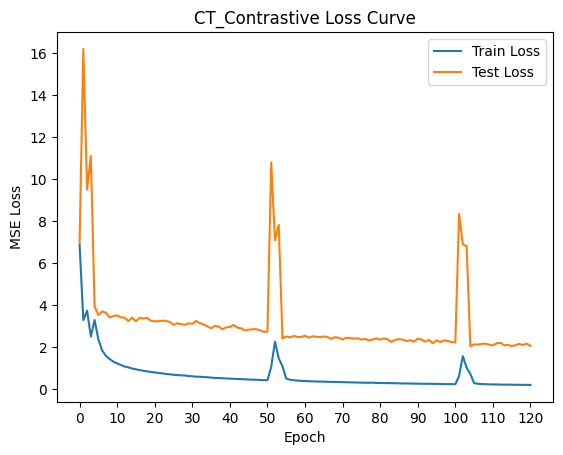

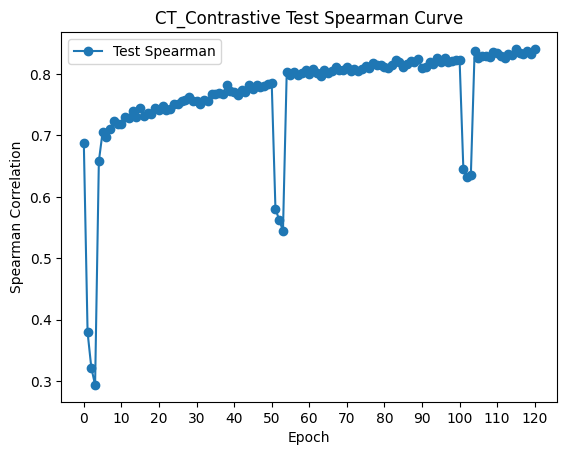

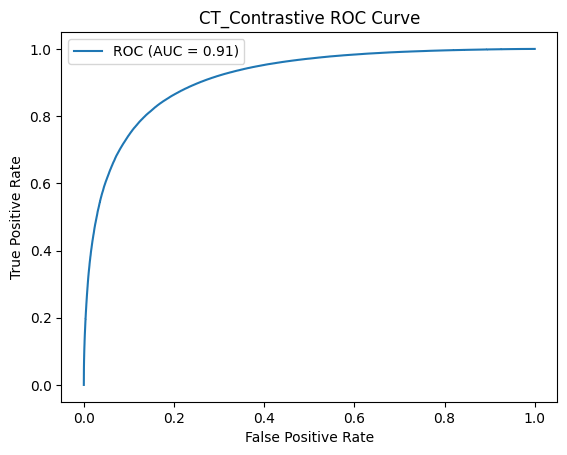

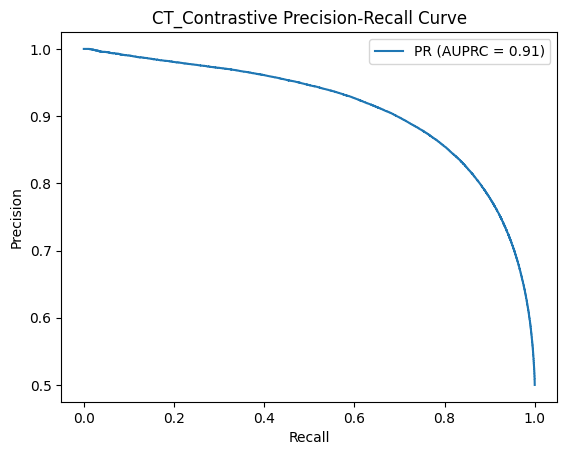

Final Test Accuracy (binarized):  0.8338
Final Test Precision (binarized): 0.8420
Final Test Recall (binarized):    0.8217
Done!


In [ ]:
if __name__ == "__main__":

    # --- hyperparameters & model selection ---
    model_type    = 'MLT_Contrastive'  # 'MLP_Contrastive', 'CNN_Contrastive', 'CrossAttnContrastive' or 'MLT_Contrastive'
    n_epoch       = 200
    batch_size    = 32
    train_frac    = 50                 # fraction of training batches to include in each epoch
    test_frac     = 5                  # fraction of testing batches to include in each epoch
    patience      = 10
    device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- instantiate model ---
    if model_type == 'MLP_Contrastive':
        model = MLP_Contrastive(
            d_esm=1280,
            embedding_hidden_dims=[640],
            d_emb=320,
            contrast_type='subtract', # "subtract" or "concat"
            output_hidden_dims=[160],
            dropout_rate=0.1
        ).to(device)
    elif model_type == 'CNN_Contrastive':
        model = CNN_Contrastive(d_esm=1280, use_first_fitness=True).to(device)
    elif model_type == 'CrossAttnContrastive':
        model = CrossAttnContrastive(
            d_esm=1280,
            d_emb=320,
            hidden_dims=[160],
            contrast_type='subtract', # "subtract" or "concat"
            dropout_rate=0.1
        ).to(device)
    else:
        model = MLT_Contrastive(
            d_esm=1280,
            d_model=256,
            nhead=4,
            dim_ff=1024,
            num_groups=3,
            blocks_per_group=2,
            max_len=101,
            use_first_fitness=True,
            dropout_rate=0.1,
        ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=4e-6, weight_decay=1e-4)

    # --- load & preprocess data ---
    n_round = 3
    train_idx1, train_idx2, train_fit1, train_lbl = [], [], [], []
    test_idx1,  test_idx2,  test_fit1,  test_lbl  = [], [], [], []

    emb_list = []
    offset = 0
    for r in [f'r{i}' for i in range(1, n_round+1)]:
        emb = np.load(f'/content/drive/MyDrive/Mid_1_data_train/ESM_emb_{r}.npy')
        emb_list.append(emb)
        seq2idx = pickle.load(open(f'/content/drive/MyDrive/Mid_1_data_train/seq_to_index_{r}.pkl','rb'))
        df_tr = pd.read_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_contrastive_train_{r}.csv').sample(frac=1, random_state=1).reset_index(drop=True)
        df_te = pd.read_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_contrastive_test_{r}.csv')

        # seq2idx is a dictionary mapping sequence in train/test set to index in ESM_emb, so have to plus the previous num of samples in emb if aggregating emb
        train_idx1 += [seq2idx[s.rstrip('*')]+offset for s in df_tr['seq_1']]
        train_idx2 += [seq2idx[s.rstrip('*')]+offset for s in df_tr['seq_2']]
        train_fit1 += [float(f) for f in df_tr['fitness_1']]
        train_lbl  += [float(y) for y in df_tr['label']]

        test_idx1  += [seq2idx[s.rstrip('*')]+offset for s in df_te['seq_1']]
        test_idx2  += [seq2idx[s.rstrip('*')]+offset for s in df_te['seq_2']]
        test_fit1  += [float(f) for f in df_te['fitness_1']]
        test_lbl   += [float(y) for y in df_te['label']]

        offset += emb.shape[0]
    emb = np.concatenate(emb_list)


    # --- zero‐skill baseline ---
    model.eval()
    # train baseline
    zero_train_preds, zero_train_targets = [], []
    nbt = math.ceil(len(train_lbl)/batch_size)
    # randomly select the training zero-skill batch set to save running time
    b_set = random.sample(range(nbt), math.ceil(nbt/train_frac))
    for b in tqdm(b_set, desc="Zero-skill train"):
        e1,e2,f1,y = load_data(train_idx1, train_idx2, train_fit1, train_lbl, emb, b, batch_size, device)
        p = model(e1,e2,f1)
        zero_train_preds.append(p.detach().cpu().numpy())
        zero_train_targets.append(y.detach().cpu().numpy())
    zero_train_preds = np.concatenate(zero_train_preds)
    zero_train_targets = np.concatenate(zero_train_targets)
    zero_train_loss = np.mean((zero_train_preds-zero_train_targets)**2)
    zero_train_spear, _ = spearmanr(zero_train_preds, zero_train_targets)
    del zero_train_preds
    del zero_train_targets

    # test baseline
    zero_test_preds, zero_test_targets = [], []
    nbe = math.ceil(len(test_lbl)/batch_size)
    # randomly select the testing zero-skill batch set to save running time
    b_set = random.sample(range(nbe), math.ceil(nbe/test_frac))
    for b in tqdm(b_set, desc="Zero-skill test"):
        e1,e2,f1,y = load_data(test_idx1, test_idx2, test_fit1, test_lbl, emb, b, batch_size, device)
        p = model(e1,e2,f1)
        zero_test_preds.append(p.detach().cpu().numpy())
        zero_test_targets.append(y.detach().cpu().numpy())
    zero_test_preds = np.concatenate(zero_test_preds)
    zero_test_targets = np.concatenate(zero_test_targets)
    zero_test_loss = np.mean((zero_test_preds-zero_test_targets)**2)
    zero_test_spear, _ = spearmanr(zero_test_preds, zero_test_targets)
    del zero_test_preds
    del zero_test_targets

    print(f"Zero‐skill Train ▶ loss={zero_train_loss:.4f}, Spear={zero_train_spear:.4f}")
    print(f"Zero‐skill Test  ▶ loss={zero_test_loss:.4f}, Spear={zero_test_spear:.4f}")

    train_losses = [zero_train_loss]
    test_losses  = [zero_test_loss]
    test_spears  = [zero_test_spear]

    # --- training loop with early stopping on test loss ---
    best_test_loss = float('inf')
    patience_ctr = 0
    for epoch in range(1, n_epoch+1):
        tr_loss = train_epoch(model, optimizer,
                              train_idx1, train_idx2,
                              train_fit1, train_lbl,
                              emb, batch_size, epoch, device, train_frac)
        te_loss, te_spear, _, _ = test_epoch(
            model,
            test_idx1, test_idx2,
            test_fit1, test_lbl,
            emb, batch_size, epoch, device, test_frac
        )
        train_losses.append(tr_loss)
        test_losses.append(te_loss)
        test_spears.append(te_spear)

        print(f"Epoch {epoch:3d} ▶ Train Loss {tr_loss:.4f} | Test Loss {te_loss:.4f} | Spear {te_spear:.4f}")

        if te_loss < best_test_loss:
            best_test_loss = te_loss
            patience_ctr = 0
            # save model & predictions
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Mid_1_Contrast_results/{model_type}_best.pt")
        else:
            patience_ctr += 1
        if epoch > train_frac and patience_ctr >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # rerun test on the entire test set
    state = torch.load(f"/content/drive/MyDrive/Mid_1_Contrast_results/{model_type}_best.pt", map_location=device)
    model.load_state_dict(state)
    te_loss, te_spear, te_preds, te_targs = test_epoch(
        model,
        test_idx1, test_idx2,
        test_fit1, test_lbl,
        emb, batch_size, epoch, device
    )
    best_preds = te_preds.copy()
    best_targs = te_targs.copy()


    # --- plot loss & Spearman curves ---
    epochs = range(len(train_losses))
    ticks  = np.arange(0, len(train_losses), 10)

    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses,  label="Test Loss")
    plt.xticks(ticks)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"{model_type} Loss Curve")
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/Mid_1_Contrast_results/{model_type}_loss.png")

    plt.figure()
    plt.plot(epochs, test_spears, marker='o', label="Test Spearman")
    plt.xticks(ticks)
    plt.xlabel("Epoch")
    plt.ylabel("Spearman Correlation")
    plt.title(f"{model_type} Test Spearman Curve")
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/Mid_1_Contrast_results/{model_type}_spearman.png")
    plt.show()

    # --- save final predictions & targets ---
    with open(f"/content/drive/MyDrive/Mid_1_Contrast_results/{model_type}_preds.pkl", "wb") as f:
        pickle.dump({"preds": best_preds, "targets": best_targs}, f)



    # --- Compute and plot ROC and PR curves (binarized at 0) ---
    # best_preds and best_targs are NumPy arrays of shape (N,)

    # 1) Binarize
    binary_targets = (best_targs > 0).astype(int)
    binary_preds   = (best_preds > 0).astype(int)

    # 2) AUC & AUPRC (use the continuous scores for curve)
    auc_score   = roc_auc_score(binary_targets, best_preds)
    prauc_score = average_precision_score(binary_targets, best_preds)

    # ROC curve
    fpr, tpr, _ = roc_curve(binary_targets, best_preds)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_score:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_type} ROC Curve")
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/Mid_1_Contrast_results/{model_type}_roc_curve.png")

    # Precision‐Recall curve
    precision, recall, _ = precision_recall_curve(binary_targets, best_preds)
    plt.figure()
    plt.plot(recall, precision, label=f"PR (AUPRC = {prauc_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_type} Precision‐Recall Curve")
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/Mid_1_Contrast_results/{model_type}_pr_curve.png")
    plt.show()

    # --- Final classification metrics ---
    final_accuracy  = accuracy_score(binary_targets, binary_preds)
    final_precision = precision_score(binary_targets, binary_preds, zero_division=0)
    final_recall    = recall_score(   binary_targets, binary_preds, zero_division=0)

    print(f"Final Test Accuracy (binarized):  {final_accuracy:.4f}")
    print(f"Final Test Precision (binarized): {final_precision:.4f}")
    print(f"Final Test Recall (binarized):    {final_recall:.4f}")

    print("Done!")